In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import models
from torchsummary import summary
import numpy as np
import pandas as pd

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # ResNet expects 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define dataset paths
train_dir = "/Users/emmanuelgeorgep/Desktop/temp/Dataset/Train"
test_dir = "/Users/emmanuelgeorgep/Desktop/temp/Dataset/Test"

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset info
print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))
print("Classes:", train_dataset.classes)

/opt/anaconda3/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Train samples: 12000
Test samples: 2000
Classes: ['Blocked', 'Normal']


In [2]:
import torch
import torch.nn as nn
from torchvision import models

class Teacher(nn.Module):
    def __init__(self, pretrained=True):
        super(Teacher, self).__init__()

        self.base_model = models.resnet18(pretrained=pretrained)
        
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_features, 2)  # Binary classification

    def forward(self, x):
        return self.base_model(x)
        
teacher = Teacher(pretrained=False).to('mps')
teacher.load_state_dict(torch.load("/Users/emmanuelgeorgep/Desktop/temp/Teacher-KL.pth"))

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
class Student(nn.Module):
    def __init__(self, num_classes=2, f=32, k=3, u=256, r=0.5):
        super(Student, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=f, kernel_size=k, padding=1),
            nn.BatchNorm2d(f),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=f, out_channels=f, kernel_size=k, padding=1),
            nn.BatchNorm2d(f),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=f, out_channels=f, kernel_size=k, padding=1),
            nn.BatchNorm2d(f),
            nn.MaxPool2d(kernel_size=2),
        )

        self.flatten = nn.Flatten()

        self.classifier = nn.Sequential(
            nn.Linear(f * 16 * 16, u),  # assuming input image size is 128x128
            nn.ReLU(),
            nn.BatchNorm1d(u),
            nn.Dropout(r),
            nn.Linear(u, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

student = Student(num_classes=len(train_dataset.classes)).to('mps')
student.load_state_dict(torch.load("/Users/emmanuelgeorgep/Desktop/temp/Student-KL.pth"))

<All keys matched successfully>

In [ ]:
import torch.optim as optim

def train_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate, T, soft_target_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.to(device)
    teacher.eval()  
    student.train() 

    losses = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                teacher_logits = teacher(inputs)

            student_logits = student(inputs)

            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

            label_loss = ce_loss(student_logits, labels)
 
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        losses.append(running_loss / len(train_loader))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
    return losses
    
student_KL = Student()
student_KL = student_KL.to("mps")
losses_KL = train_knowledge_distillation(teacher=teacher, student=student_KL, train_loader=train_loader, epochs=10, learning_rate=0.001, T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, device="mps")

Epoch 1/10, Loss: 0.40074720690647764
Epoch 2/10, Loss: 0.2447256121834119
Epoch 3/10, Loss: 0.17210890816648802
Epoch 4/10, Loss: 0.14246930020054183
Epoch 5/10, Loss: 0.13100759889930486
Epoch 6/10, Loss: 0.1072801832742989
Epoch 7/10, Loss: 0.10189406269043684
Epoch 8/10, Loss: 0.08192707074681918
Epoch 9/10, Loss: 0.06606489492580295
Epoch 10/10, Loss: 0.09565130891650915


In [7]:
from sklearn.metrics import classification_report

def test_model(model, test_loader, device, class_names):
    model.eval()
    model.to(device)
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _,preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    print(classification_report(all_labels, all_preds, target_names=class_names))

In [15]:
import matplotlib.pyplot as plt

def plot_loss(loss_values,title):
    
    epochs = list(range(1, len(loss_values) + 1))

    plt.figure(figsize=(8, 4))
    plt.plot(epochs, loss_values, marker='o', linestyle='-', color='blue', label='Training Loss')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks(epochs)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [14]:
print("STUDENT MODEL with KL-divergence")
test_model(student_KL, test_loader, "mps", class_names=train_dataset.classes)

STUDENT MODEL with KL-divergence
              precision    recall  f1-score   support

     Blocked       0.98      0.94      0.96      1000
      Normal       0.95      0.98      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



In [9]:
print("TEACHER MODEL")
test_model(teacher, test_loader, "mps", class_names=train_dataset.classes)

TEACHER MODEL
              precision    recall  f1-score   support

     Blocked       1.00      0.96      0.98      1000
      Normal       0.97      1.00      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



In [10]:
print("STUDENT MODEL")
test_model(student, test_loader, "mps", class_names=["Blocked","Normal"])

STUDENT MODEL
              precision    recall  f1-score   support

     Blocked       0.97      0.95      0.96      1000
      Normal       0.95      0.97      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



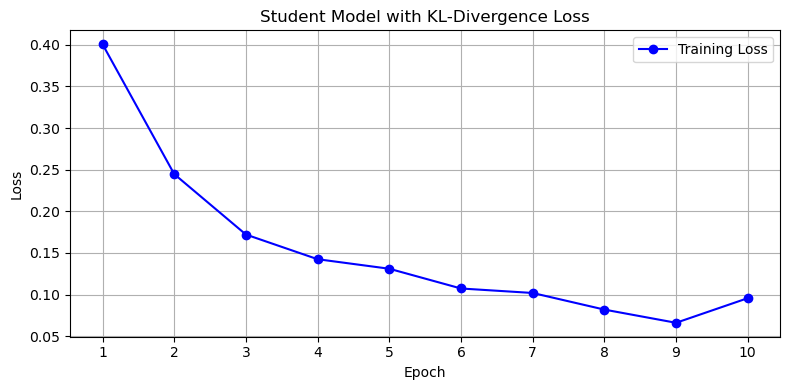

In [16]:
plot_loss(losses_KL, "Student Model with KL-Divergence Loss")
torch.save(student_KL.state_dict(), "/Users/emmanuelgeorgep/Desktop/temp/Student-KD-KL.pth")